## Variable Labeling Ratio with blunt tip.

In [1]:
from pathlib import Path
import json
import sys
sys.path.append("../../../../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from tqdm.auto import tqdm

data_dir = Path('/home/hadim/Drive/Data/Postdoc/Fake Microtubules/anamic/accuracy')

experiment_name = 'noise_factor'
experiment_dir = data_dir / experiment_name

In [2]:
data = pd.read_csv(experiment_dir / "analysis.csv")

# Compute the horizontal and vertical component of the error vector.

# Compute the vector of each MT
data['mt_vec_x'] = np.nan
data['mt_vec_y'] = np.nan
data[['mt_vec_x', 'mt_vec_y']] = data[['tip_end_x', 'tip_end_y']].values - data[['tip_start_x', 'tip_start_y']].values

# Compute the vector of each error
data['error_vec_x'] = np.nan
data['error_vec_y'] = np.nan
data[['error_vec_x', 'error_vec_y']] = data[['x', 'y']].values - data[['tip_end_x', 'tip_end_y']].values

# Compute norm for error and mt vectors.
data['mt_vec_norm'] = np.sqrt(np.sum(data[['mt_vec_x', 'mt_vec_y']] ** 2, axis=1))
data['error_vec_norm'] = np.sqrt(np.sum(data[['error_vec_x', 'error_vec_y']] ** 2, axis=1))

# Add an `error` column.
data['error'] = np.sqrt(np.sum(data[['error_vec_x', 'error_vec_y']] ** 2, axis=1))

# Compute the scalar projection (horizontal error)
error_vec = data[['error_vec_x', 'error_vec_y']].values
mt_vec = data[['mt_vec_x', 'mt_vec_y']].values
data['horizontal_error'] = np.sum((mt_vec * error_vec), axis=1) / data['mt_vec_norm']
data['horizontal_error_absolute'] = np.abs(data['horizontal_error'])

# Compute the vertical error using Pythagor theorem.
data['vertical_error'] = np.sqrt(np.abs((data['error_vec_norm'].values ** 2) - (data['horizontal_error'].values ** 2)))

# Sanity check.
assert np.allclose(data['error'] ** 2, (data['horizontal_error'] ** 2 + data['vertical_error'] ** 2))

# Save back the data file.
data.to_csv(experiment_dir / "analysis.csv")

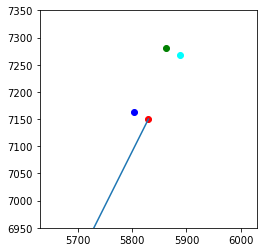

In [3]:
# Visualize vertical and horizontal error for one image.
idx = 768
idx = 155

datum = data.iloc[idx]

tip_end = datum[['tip_end_x', 'tip_end_y']].values
mt_vec = datum[['mt_vec_x', 'mt_vec_y']].values

horizontal_error = tip_end + (mt_vec / datum['mt_vec_norm']) * datum['horizontal_error']
vertical_error = anamic.geometry.get_normal_points(mt_vec, tip_end, datum['vertical_error'])[0]

fig, ax = plt.subplots()

datum = data.iloc[idx]

xx = datum[['tip_start_x', 'tip_end_x']]
yy = datum[['tip_start_y', 'tip_end_y']]
ax.plot(xx, yy)

ax.scatter(datum['tip_end_x'], datum['tip_end_y'], color='red')

ax.scatter(datum['x'], datum['y'], color='green')
ax.scatter(horizontal_error[0], horizontal_error[1], color='cyan')
ax.scatter(vertical_error[0], vertical_error[1], color='blue')

d = 200
ax.set_xlim(datum['tip_end_x']-d, datum['tip_end_x']+d)
ax.set_ylim(datum['tip_end_y']-d, datum['tip_end_y']+d)

ax.set_aspect('equal')

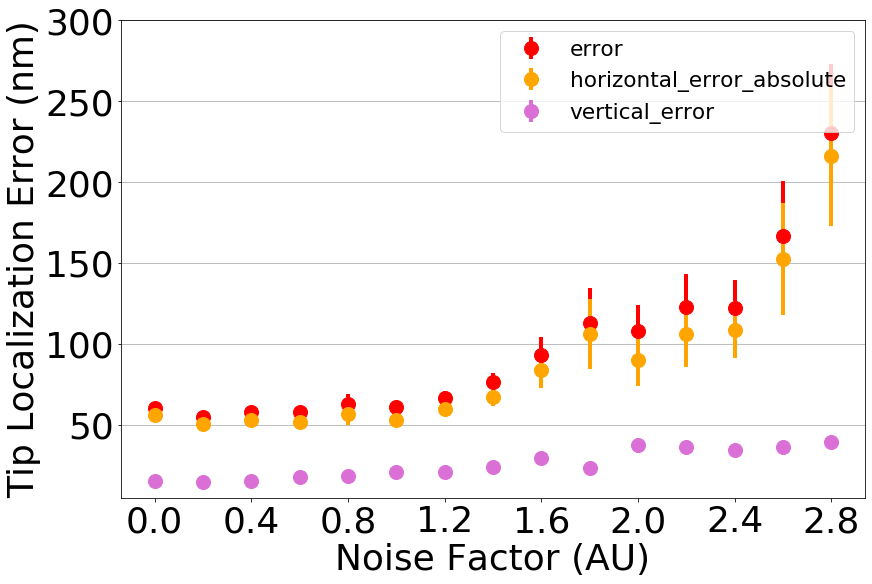

In [8]:
# Plot tip localization error.

x_feature = 'parameter'
y_feature = 'vertical_error'

font_size = 36

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

x = data[x_feature]
gb = data.groupby(x_feature)
average = gb.mean()

y_features = ['error', 'horizontal_error_absolute', 'vertical_error']
colors = ['red', 'orange', 'orchid']
for y_feature, color in zip(y_features, colors):
  y = data[y_feature]
  x_average = average.index
  y_average = average[y_feature]
  yerr = gb.sem()[y_feature]
  label = y_feature
  ax.errorbar(x_average, y_average, yerr=yerr, fmt='o', label=label, color=color, elinewidth=4, markersize=14)

ax.set_xlabel("Noise Factor (AU)", fontsize=font_size)
ax.set_ylabel("Tip Localization Error (nm)", fontsize=font_size)

ax.set_xticks(np.arange(0, 2.9, 0.4))
ax.set_yticks(np.arange(0, 400, 50))

ax.set_ylim(5, 300)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    
ax.yaxis.grid()
ax.legend(fontsize=font_size*0.6)
    
fig.savefig(experiment_dir / "error.png")

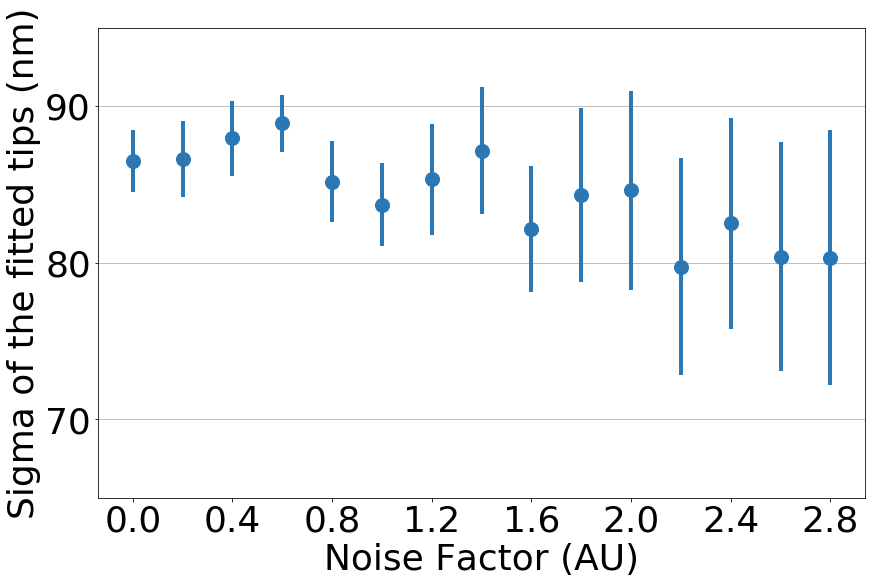

In [7]:
# Plot sigma of the fitted tips.

x_feature = 'parameter'
y_feature = 'sigma'

font_size = 36
color = "#2a77b4"

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

x = data[x_feature]
y = data[y_feature]

#ax.scatter(x, y, alpha=0.4, marker='x')

gb = data.groupby(x_feature)
average = gb.mean()

x_average = average.index
y_average = average[y_feature]
ax.errorbar(x_average, y_average, yerr=gb.sem()[y_feature], fmt='o', color=color, elinewidth=4, markersize=14)

ax.set_xlabel("Noise Factor (AU)", fontsize=font_size)
ax.set_ylabel("Sigma of the fitted tips (nm)", fontsize=font_size)

ax.set_xticks(np.arange(0, 2.9, 0.4))
ax.set_yticks(np.arange(0, 110, 10))

ax.set_ylim(65, 95)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    
ax.yaxis.grid()
    
fig.savefig(experiment_dir / "sigma.png")